# Pre-Processing

In this notebook the chess data will be pre-processed for model development. 

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
from sklearn.preprocessing import scale
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter

In [58]:
chess_df = pd.read_pickle('EDA_df.pkl')
chess_df.head(3)

,id,rated,turns,victory_status,winner,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,time_allotted,increment
0,TZJHLljE,False,13,outoftime,white,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,15,2
1,l1NXvwaE,True,16,resign,black,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,5,10
2,mIICvQHh,True,61,mate,white,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,5,10


There are a few things to do here. First is to encode categorical columns. Next is to standardize the numeric columns. And the last thing to do is to tokenize the text columns. But first, let's make a copy of the dataframe in case we want to keep the original for whatever reason. Also, let's drop the id columns.

In [59]:
#let's make a copy and work with this, in case we need the original later on
df = chess_df.copy()

In [60]:
df.drop(columns=['id', 'white_id', 'black_id'], inplace=True)

## Encoding Categorical Columns

In [61]:
#replacing True and False values with 0's and 1's
df['rated'].replace({False:0, True:1}, inplace=True)

Next let's one hot encode the `victory_status` column.

In [62]:
#perhaps unneccessary, we can drop the one-hot encoded column with the least occurences, 
#since one column will be represented by all the other encoded columns with zero
df['victory_status'].value_counts()

resign       10695
mate          5974
outoftime     1598
draw           846
Name: victory_status, dtype: int64

In [63]:
df = pd.get_dummies(df, columns = ['victory_status'])

In [64]:
#now lets get rid of the victory_status column and the encoded draw column
df.drop(columns=['victory_status_draw'], inplace=True)

In [65]:
df.head(2)

,rated,turns,winner,white_rating,black_rating,moves,opening_eco,opening_name,opening_ply,time_allotted,increment,victory_status_mate,victory_status_outoftime,victory_status_resign
0,0,13,white,1500,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,15,2,0,1,0
1,1,16,black,1322,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,5,10,0,0,1


## Standardizing Numeric Columns

The numeric columns need to be adjusted before modeling. We can standardize them with their respective means and standard deviation. We may use algorithms that make assumptions that depends on the columns having a gaussian distribution, which is why we standardize, but we should check the gaussian distributions first.

In [66]:
#here are out numeric columns all in one list 
numeric_cols = ['turns', 'white_rating', 'black_rating', 'opening_ply', 'time_allotted', 'increment']

In [67]:
#make a function to quickly plot the probability distribution function of numeric columns
def normal_dist(feature_name, dataframe, ax=None):
    feature_df = dataframe[[feature_name]]
    
    #mean ad std
    mean = feature_df.mean()
    std = feature_df.std()
    
    #get the probability distribution function
    pdf = stats.norm.pdf(feature_df.sort_values(by=feature_name), loc=mean, scale=std)
    
    fig = ax.plot(feature_df.sort_values(by=feature_name)[feature_name], pdf)
    return fig

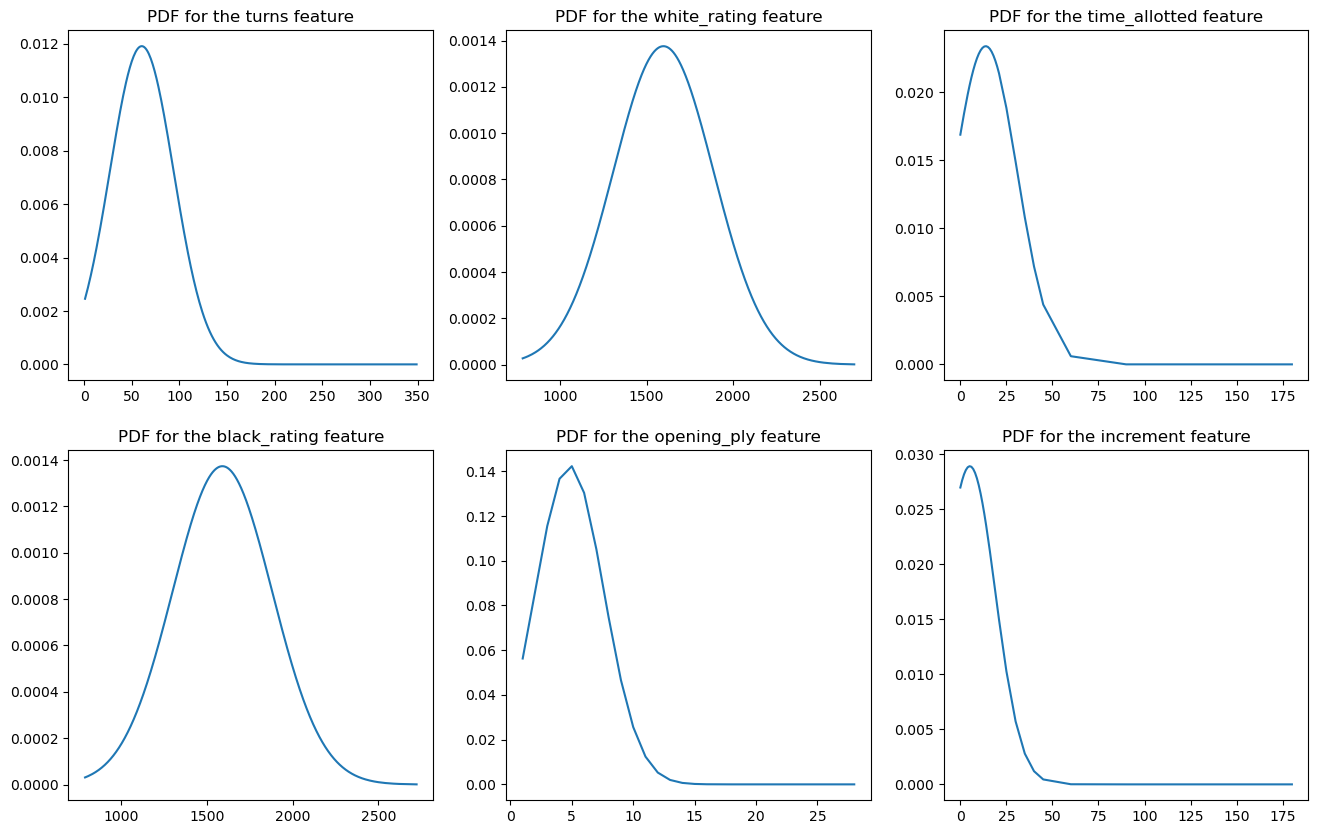

In [68]:
#making all plots in one subplot to make it easier to see them all at once
fig, axs = plt.subplots(2, 3, figsize=(16,10))
normal_dist('turns', df, axs[0, 0])
axs[0, 0].title.set_text('PDF for the turns feature')

normal_dist('white_rating', df, axs[0, 1])
axs[0, 1].title.set_text('PDF for the white_rating feature')

normal_dist('black_rating', df, axs[1, 0])
axs[1, 0].title.set_text('PDF for the black_rating feature')

normal_dist('opening_ply', df, axs[1, 1])
axs[1, 1].title.set_text('PDF for the opening_ply feature')

normal_dist('time_allotted', df, axs[0, 2])
axs[0, 2].title.set_text('PDF for the time_allotted feature')

normal_dist('increment', df, axs[1, 2])
axs[1, 2].title.set_text('PDF for the increment feature')
plt.show()

So it looks like all the numeric features follow a normal distribution, though a few are notably skewed. In any case, this gives us good reason to continue with standardizing these variables.

In [69]:
standardized = scale(df[numeric_cols])

stand_df = pd.DataFrame(standardized, columns = numeric_cols)

stand_df.head(3)

,turns,white_rating,black_rating,opening_ply,time_allotted,increment
0,-1.418858,-0.335500,-1.373962,0.065835,0.071153,-0.227871
1,-1.329272,-0.949261,-1.132944,-0.291536,-0.514602,0.351493
2,0.014518,-0.349292,-0.310038,-0.648908,-0.514602,0.351493


Let's double check to make sure this worked and that the pdf's are still the same, but scaled.

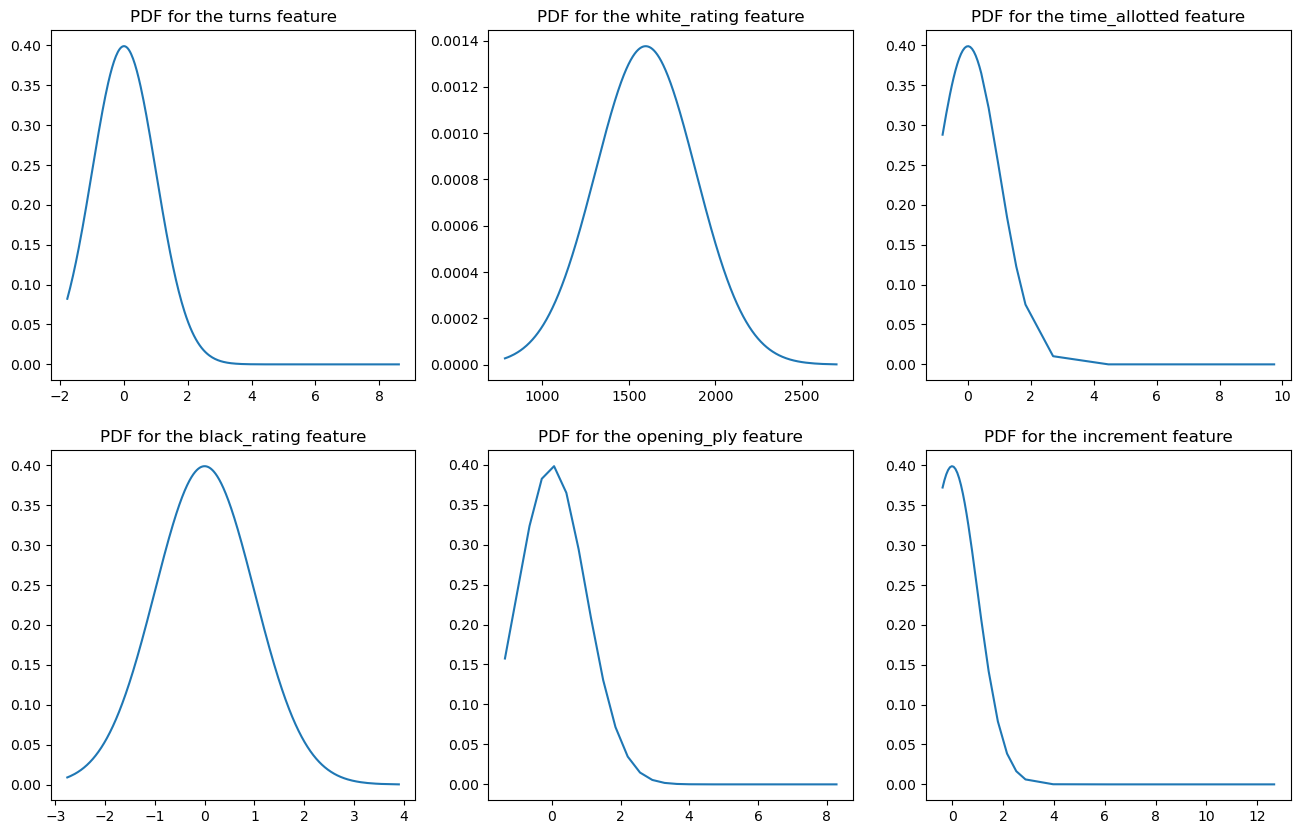

In [70]:
fig, axs = plt.subplots(2, 3, figsize=(16,10))
normal_dist('turns', stand_df, axs[0, 0])
axs[0, 0].title.set_text('PDF for the turns feature')

normal_dist('white_rating', df, axs[0, 1])
axs[0, 1].title.set_text('PDF for the white_rating feature')

normal_dist('black_rating', stand_df, axs[1, 0])
axs[1, 0].title.set_text('PDF for the black_rating feature')

normal_dist('opening_ply', stand_df, axs[1, 1])
axs[1, 1].title.set_text('PDF for the opening_ply feature')

normal_dist('time_allotted', stand_df, axs[0, 2])
axs[0, 2].title.set_text('PDF for the time_allotted feature')

normal_dist('increment', stand_df, axs[1, 2])
axs[1, 2].title.set_text('PDF for the increment feature')
plt.show()

Look's like everything worked as intended. To finish this, let's replace the numeric columns with these standardized columns.

In [71]:
#first dropping the numeric columns and then adding their standardized version back
df2 = df.drop(columns=numeric_cols).join(stand_df)
df2.head(3)

,rated,winner,moves,opening_eco,opening_name,victory_status_mate,victory_status_outoftime,victory_status_resign,turns,white_rating,black_rating,opening_ply,time_allotted,increment
0,0,white,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,0,1,0,-1.418858,-0.335500,-1.373962,0.065835,0.071153,-0.227871
1,1,black,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,0,0,1,-1.329272,-0.949261,-1.132944,-0.291536,-0.514602,0.351493
2,1,white,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,1,0,0,0.014518,-0.349292,-0.310038,-0.648908,-0.514602,0.351493


## Handling the Text Columns

The features with text data are the `moves`, `opening_eco`, and `opening_name` columns. We need to tokenize them for modelling.

In [72]:
#we will use the count vectorizer method
cv = CountVectorizer()

cv_trans = cv.fit_transform(df2['moves'])

In [73]:
cv_df = pd.DataFrame(cv_trans.toarray(), columns=cv.get_feature_names_out()).add_prefix('Counts_')

In [74]:
#making a new dataframe with the vectorized features of the moves column
df3 = pd.concat([df2, cv_df], axis=1)

In [75]:
#now lets drop the moves column
df3.drop(columns=['moves'], inplace=True)

Next let's deal with the opening columns. Let's do a bit of EDA on them first. Since we know the `opening_eco` is an umbrella code for the types of openings that appear in `opening_name`, it may be redundant to have both of these columns. We also saw that from the previous EDA notebook, values in the `opening_eco` column tend to correspond to values in the `opening_name` column that have the same first few word before the column, indicating the type of opening move. We can see this again here.

In [76]:
df3[['opening_name', 'opening_eco']][df3['opening_eco'] == 'D10'].head()

,opening_name,opening_eco
0,Slav Defense: Exchange Variation,D10
26,Slav Defense,D10
396,Slav Defense,D10
554,Slav Defense #2,D10
611,Slav Defense: Exchange Variation,D10


From the previous notebook we know there are 365 unique values in the `opening_eco` column, so if there are also 365 unique values when just considering the first part of the `opening_name` column, then perhaps we don't need the `opening_eco` column. Most of these 'first part' values from the `opening_name` columns are before the colon. So let's split the strings on the colon, and see how many unique values of these there are. 

In [77]:
opening_dct = {}
for opening in df['opening_name'].str.split(':'):
    initial_name = opening[0]
    
    if initial_name in opening_dct:
        opening_dct[initial_name] += 1
    else:
        opening_dct[initial_name] = 1
        
len(opening_dct)

227

227 is significantly lower than 365. The discrepency probably comes from not always having a colon, or maybe having multiple colons. We could also try frequency encoding. For this we would ideally want each feature value to occur a different number of times when compared to other values. This means the frequency occurence of each feature value should be close to unqiue. Let's check this with the counter function.


In [78]:
#counting the number of times a value_count occurs. 
#If more than 1, then that means there are more than 1 feature values that have the same fequency occurence
freq_count = Counter(df['opening_eco'].value_counts())

print(freq_count.values())

dict_values([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 3, 2, 1, 1, 2, 1, 1, 1, 1, 3, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 3, 4, 2, 2, 5, 3, 3, 3, 2, 6, 1, 4, 3, 3, 5, 7, 3, 5, 8, 3, 3, 7, 4, 3, 5, 10, 15, 15, 15, 22, 21, 28, 51])


It looks like too many variables have the same frequency count, so proably best not to do a frequency encoding. In any case, let's just vectorize these like the `moves` column now.

In [79]:
cv = CountVectorizer()

cv_trans = cv.fit_transform(df2['opening_eco'])

cv_eco = pd.DataFrame(cv_trans.toarray(), columns=cv.get_feature_names_out()).add_prefix('Counts_')

df3 = pd.concat([df3, cv_eco], axis=1)

df3.drop(columns=['opening_eco'], inplace=True)

Before doing this to the `opening_name` column, let's count how many words are in the the string before and after the column. The reason for doing this is to get th parameter for the n_grams in the count vectorizer.

In [80]:
#initializing empty dict for counting
count_dct = {}

for opening in df['opening_name'].str.split(':'):
    #splitting the part of the string before the colon, to see how many words it has
    #getting rid of leading and ending whitespace
    l_str = opening[0].lstrip().rstrip()
    #getting the number of words in the string
    l = len(l_str.split(' '))
    #adding the count to the dict
    if l in count_dct:
        count_dct[l] += 1
    else:
        count_dct[l] = 1
    
    #repeating above for the words after the column, if there are any (hence the if statement)
    if len(opening) >= 2:
        #there seems to be some white space so lets get rid of it
        r_str = opening[1].lstrip().rstrip()
        r = len(r_str.split(' '))
        if r in count_dct:
            count_dct[r] += 1
        else:
            count_dct[r] = 1
    
count_dct

{2: 20850,
 3: 7214,
 6: 1619,
 7: 749,
 8: 288,
 10: 122,
 5: 249,
 4: 241,
 12: 61,
 1: 155,
 11: 60,
 9: 15,
 13: 9}

Seems like there are a lot of strings with two and three words, so lets put that in. Edit: ngram_range should just be (1, 2) because otherwise there will be too many features/columns.

In [81]:
cv = CountVectorizer(ngram_range = (1, 2))

cv_trans = cv.fit_transform(df2['opening_name'])

cv_name = pd.DataFrame(cv_trans.toarray(), columns=cv.get_feature_names_out()).add_prefix('Counts_name_')

df3 = pd.concat([df3, cv_name], axis=1)

df3.drop(columns=['opening_name'], inplace=True)

In [82]:
df3.head(3)

,rated,winner,victory_status_mate,victory_status_outoftime,victory_status_resign,turns,white_rating,black_rating,opening_ply,time_allotted,...,Counts_name_zinnowitz,Counts_name_zinnowitz variation,Counts_name_zukertort,Counts_name_zukertort gambit,Counts_name_zukertort opening,Counts_name_zukertort system,Counts_name_zukertort variation,Counts_name_zurich,Counts_name_zurich gambit,Counts_name_zurich variation
0,0,white,0,1,0,-1.418858,-0.335500,-1.373962,0.065835,0.071153,...,0,0,0,0,0,0,0,0,0,0
1,1,black,0,0,1,-1.329272,-0.949261,-1.132944,-0.291536,-0.514602,...,0,0,0,0,0,0,0,0,0,0
2,1,white,1,0,0,0.014518,-0.349292,-0.310038,-0.648908,-0.514602,...,0,0,0,0,0,0,0,0,0,0


## Encoding the Target

With all the features properly handled, all thats left is the target variable. We just need to use a label encoder to encode it as it is a categorical variable with three categories, which are:

In [83]:
df3['winner'].unique()

array(['white', 'black', 'draw'], dtype=object)

In [84]:
#label encoder will turn categories into integers, which is neccessary for some algorithms
le = LabelEncoder()

In [85]:
le.fit(df3['winner'])

LabelEncoder()

In [86]:
le.classes_

array(['black', 'draw', 'white'], dtype=object)

In [87]:
labels = le.transform(df3['winner'])

In [88]:
labels_df = pd.DataFrame(labels)

#rename the column
labels_df.rename(columns={0: 'winner_label'}, inplace=True)

#put dataframes together
df3 = pd.concat([df3, labels_df], axis=1)

df3.drop(columns=['winner'], inplace=True)

## Training and Testing Sets

With all the data pre-processed, we can split the data into training and testing splits.

In [89]:
#features to train on
X = df3.drop(columns=['winner_label'])

#taget variable
y = df3['winner_label']

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [91]:
#getting our dataframes back so we can save them for the next notebook
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [92]:
#saving them as pickle files
train_df.to_pickle('train_df.pkl')
test_df.to_pickle('test_df.pkl')

## Summary

To sum up, in this notebook we turn categorical variables by either label encoding them or one-hot encoding them. Then we made sure all numeric columns follow some sort of normal distribution, before standardizing them. And finally, we vectorized the text columns, before splitting and saving the final pre-processed dataframe as pickle files.